# Z-ify the difference maps

In [11]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import nibabel as nib
import nilearn as nil
from scipy import io as sio
from matplotlib import gridspec
from nilearn import plotting as nlp
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Paths
# Let's start with the full sample, maybe data, mean subtype at scale 7. We look at everything
pri_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale007.nii.gz'
res_path = '/data1/guilimin/abide/subtype/sc7/full_maybe/network_{}/'
mod_path = '/data1/guilimin/abide/pheno/sc7/model_full_maybe_sc7.csv'
mas_path = '/data1/guilimin/abide/masks/template_mask.nii.gz'
out_path = '/home/surchs/GDrive/PhD/Conferences/HBM2016/Poster/Figures/Subtypes/'
#sbt_effects = ((1,2),(1,5),(2,5),(3,1),(3,2),(6,1),(6,5))

In [4]:
mod = pd.read_csv(mod_path)
mod.DX_GROUP.replace({1:'Patient', 2:'Control'}, inplace=True)

In [5]:
pat_ind = (mod.DX_GROUP=='Patient').values
ctr_ind = (mod.DX_GROUP=='Control').values

In [6]:
m_img = nib.load(mas_path)
mask = m_img.get_data().astype(bool)
m_vec = np.reshape(mask, np.prod(mask.shape), order='F')

In [7]:
p_img = nib.load(pri_path)
prior = p_img.get_data()
p_vec = prior[mask]

In [14]:
net = np.array([])
diag = np.array([])
within = np.array([])
for network in np.arange(7)+1:
    ns = sio.loadmat('/data1/guilimin/abide/subtype/sc7/full_maybe_noreg/network_{0}/network_{0}_stack.mat'.format(network))
    stack = ns['stack']
    
    tmp_pat = np.zeros_like(m_vec, dtype=float)
    tmp_pat[m_vec] = np.mean(stack[pat_ind, :],0)
    tmp_pat = np.reshape(tmp_pat, mask.shape, order='F')
    
    pat_img = nib.Nifti1Image(tmp_pat, header=m_img.get_header(), affine=m_img.get_affine())
    pat_name = 'net_{}_patient_map.nii.gz'.format(network)
    #nib.save(pat_img, os.path.join(out_path, pat_name))
    
    tmp_ctr = np.zeros_like(m_vec, dtype=float)
    tmp_ctr[m_vec] = np.mean(stack[ctr_ind, :],0)
    tmp_ctr = np.reshape(tmp_ctr, mask.shape, order='F')
    
    ctr_img = nib.Nifti1Image(tmp_ctr, header=m_img.get_header(), affine=m_img.get_affine())
    ctr_name = 'net_{}_control_map.nii.gz'.format(network)
    #nib.save(ctr_img, os.path.join(out_path, ctr_name))
        
    n_vec_pat = tmp_pat[mask]
    n_vec_ctr = tmp_ctr[mask]
    
    within_pat = n_vec_pat[p_vec==network]
    within_ctr = n_vec_ctr[p_vec==network]
    
    within = np.concatenate((within, within_pat))
    diag = np.concatenate((diag, np.ones_like(within_pat)))
    net = np.concatenate((net, np.ones_like(within_pat)*network))
                         
    within = np.concatenate((within, within_ctr))
    diag = np.concatenate((diag, np.zeros_like(within_ctr)))
    net = np.concatenate((net, np.ones_like(within_ctr)*network))

df = pd.DataFrame(data={'within':within, 'Diagnose':diag, 'Network':net})
df.Diagnose.replace({0:'Control', 1:'Patient'}, inplace=True)

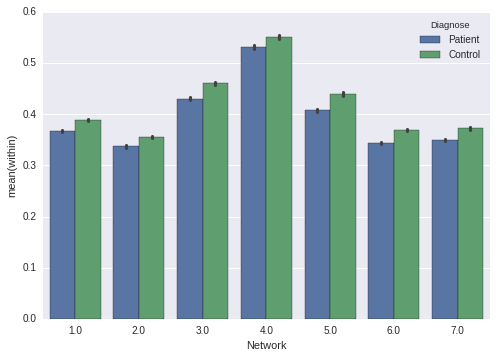

In [15]:
ax = sb.barplot(x="Network", y="within", hue="Diagnose", data=df)